In [42]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [8]:
# Load data from company on yahoo finance and create dataframe
stock = 'AAPL'
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2019, 1, 1)

#Already in dataframe
data = pdr.DataReader(stock, 'yahoo', start, end)

In [46]:
#Visualization of data
print(data)
low_high = data.drop(columns=['Open', 'Close', 'Volume', 'Adj Close'])
open_close = data.drop(columns=['High', 'Low', 'Volume', 'Adj Close'])

                 High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2010-01-04   7.660714   7.585000   7.622500   7.643214  493729600.0   6.562589
2010-01-05   7.699643   7.616071   7.664286   7.656429  601904800.0   6.573936
2010-01-06   7.686786   7.526786   7.656429   7.534643  552160000.0   6.469368
2010-01-07   7.571429   7.466071   7.562500   7.520714  477131200.0   6.457408
2010-01-08   7.571429   7.466429   7.510714   7.570714  447610800.0   6.500340
...               ...        ...        ...        ...          ...        ...
2019-12-24  71.222504  70.730003  71.172501  71.067497   48478800.0  70.129501
2019-12-26  72.495003  71.175003  71.205002  72.477501   93121200.0  71.520912
2019-12-27  73.492500  72.029999  72.779999  72.449997  146266000.0  71.493759
2019-12-30  73.172501  71.305000  72.364998  72.879997  144114400.0  71.918091
2019-12-31  73.419998  72.379997  72.482498  73.4124

Text(0, 0.5, 'Price')

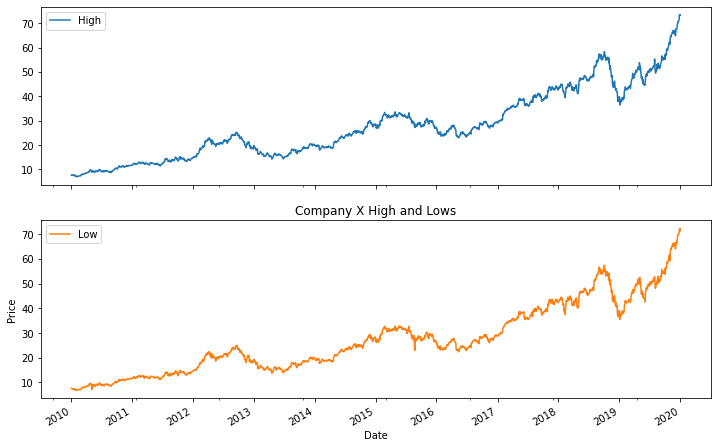

In [52]:
#Check volatility of stock
low_high.plot.line(subplots=True, figsize=(12,8))
plt.title('Company X High and Lows')
plt.xlabel('Date')
plt.ylabel('Price')


Text(0, 0.5, 'Price')

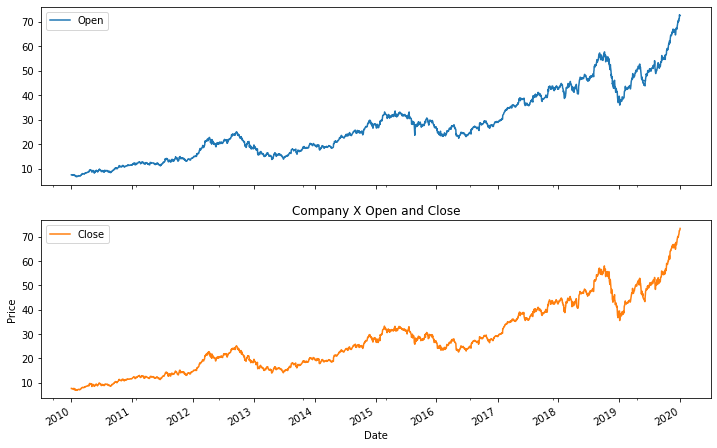

In [53]:
open_close.plot.line(subplots=True, figsize=(12,8))
plt.title('Company X Open and Close')
plt.xlabel('Date')
plt.ylabel('Price')

In [ ]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = list()
y_train = list()

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build prediction model using RNN
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Prediction of next closing
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

#Test model accuracy
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = pdr.DataReader(stock, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make prediction
x_test = list()

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)



In [ ]:
# Plot predictions in test
plt.plot(actual_prices, color='blue', label='Actual {} Price'.format(stock))
plt.plot(predicted_prices, color='green', label='Predicted {} Price'.format(stock))

plt.title('{} Price'.format(stock))
plt.xlabel('Time')
plt.ylabel('Share Price')
plt.legend()

In [3]:
#Predict future days - day trader
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

scaler.inverse_transform(real_data[-1])

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print('Prediction: {}'.format(prediction))


'Prediction: [[141.56142]]'